In [1]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from bart_single_node_responses import calculate_all_single_node_characteristics
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import shutil

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from sklearn.decomposition import PCA

set_rc()

# Behavioral Data

First step, run 17 episode evaluation suite on agents from across multiple checkpoints. Goal here is to get some primary behavior characteristics, as well as figure out the first checkpoint after which agents collect a total of >275 points across evaluation suite, then use those checkpoints (1 per agent) to collect more detailed data like node activations

In [ ]:
"""
Main section to collect a bunch of data on confidence, activations
and ramping signal
"""
import warnings
warnings.filterwarnings("ignore")

minsum = 275

give_rew = ['giverew_', 'fixprev_']
postfixes = ['pop0', 'pop0.1', 'pop0.2', 'pop0.4']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(10)
chks = np.arange(40, 243, 30)

iterators = [give_rew, postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
# Performance
last_sizes = np.zeros(sizes + [17, 50])
unpopped_sizes = np.zeros(sizes + [17, 50])
pop_rate = np.zeros(sizes + [17])
rewards = np.zeros(sizes + [17, 2500])
values = np.zeros(sizes + [17, 2500])
action_probs = np.zeros(sizes + [17, 2500])
all_lens = np.zeros(sizes + [17])
all_num_balloons = np.zeros(sizes + [17])
balloon_steps = np.full(sizes + [17, 50], -1)
button_presses = np.full(sizes + [17, 100], -1)

# Decision flow
dec_flow_scores = np.zeros(sizes + [2]) # last axis: 0=decision nodes, 1=non-dec nodes

# Ramp to threshold F1 scores
ramp_f1s = np.zeros(sizes + [6, 11]) 
ramp_indiv_contribs = np.zeros(sizes + [6, 64])

# Confidence scores
confidence_scores = np.zeros(sizes)
unconfidence_scores = np.zeros(sizes)
unconfident_points = np.zeros(sizes)
step_count = np.zeros(sizes)
all_decision_nodes = np.zeros(sizes + [17, 64])

# Cluster and PCA regressor coefs
cluster_regressor_coefs = np.zeros(sizes + [3, 64])
cluster_regressor_scores = np.zeros(sizes + [3])
cluster_ks = np.zeros(sizes)
pca_regressor_coefs = np.zeros(sizes + [3, 6])
pca_regressor_scores = np.zeros(sizes + [3])

for h, i, j, k, l in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    if step_count[h, i, j, k, l] != 0:
        continue
    if (rewards[h, i, j, k].sum(axis=(1, 2)) > minsum).any():
        continue
    
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
    
    if h == 0:
        res = giverew_evalu(model, obs_rms)
    elif h == 1:
        res = fixprev_evalu(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=50)

    # Performance
    lens = np.array([len(d) for d in res['dones']])
    num_balloons = np.array([len(d) for d in res['data']['balloon_step']])
    unpop_size = get_sizes(res, obs_rms, last_only=True)
    for ep in range(17):
        last_sizes[h, i, j, k, l, ep, :num_balloons[ep]] = res['data']['last_size'][ep]
        unpopped_sizes[h, i, j, k, l, ep, :num_balloons[ep]] = unpop_size[ep]
        pop_rate[h, i, j, k, l, ep] = np.sum(res['data']['popped'][ep]) / num_balloons[ep]
        values[h, i, j, k, l, ep, :lens[ep]] = res['values'][ep].reshape(-1)
        rewards[h, i, j, k, l, ep, :lens[ep]] = res['rewards'][ep]
        action_probs[h, i, j, k, l, ep, :lens[ep]] = res['action_probs'][ep][:, 1]
        
        presses = np.argwhere(res['actions'][ep].reshape(-1) == 1).reshape(-1)
        bsteps = res['data']['balloon_step'][ep]
        button_presses[h, i, j, k, l, ep, :len(presses)] = presses
        balloon_steps[h, i, j, k, l, ep, :len(bsteps)] = bsteps
        
    all_lens[h, i, j, k, l] = lens
    all_num_balloons[h, i, j, k, l] = num_balloons
    
    # Decision flow
    try:
        score, dec_nodes = score_decision_flow(res, model)
        dec_flow_scores[h, i, j, k, l] = score.mean(axis=0)
        all_decision_nodes[h, i, j, k, l] = dec_nodes
    except:
        pass
    
    # Confidence scores    
    non_presses = (np.vstack(res['actions']) == 0).reshape(-1)
    presses = (np.vstack(res['actions']) == 1).reshape(-1)
    aps = np.vstack(res['action_probs'])[:, 1]
    confidence_scores[h, i, j, k, l] = aps[presses].mean()
    unconfidence_scores[h, i, j, k, l] = aps[non_presses].mean()
    unconfident_points[h, i, j, k, l] = ((aps > 0.2) & (aps < 0.8)).sum() 
    step_count[h, i, j, k, l] = len(aps)
    
    # Ramp to threshold scores
    f1_scores, individual_scores = score_logistic_classifiers(res)
    ramp_f1s[h, i, j, k, l] = f1_scores
    ramp_indiv_contribs[h, i, j, k, l] = individual_scores
    # Cluster and PCA regressor scores
    # layers = ['shared0', 'shared1', 'actor0', 'actor1', 'critic0', 'critic1']
    # for z, layer in enumerate(layers):
    #     try:
    #         coefs, scores = compute_regressor_coefficients(res, by_clusters=True, layer=layer)
    #         n_clusters = coefs.shape[1]
    #         cluster_regressor_coefs[h, i, j, k, l, z, :, :n_clusters] = coefs
    #         cluster_regressor_scores[h, i, j, k, l, z] = scores
    #         cluster_ks[h, i, j, k, l, z] = n_clusters
        
    #         coefs, scores = compute_regressor_coefficients(res, by_clusters=False, layer=layer)
    #         pca_regressor_coefs[h, i, j, k, l, z] = coefs
    #         pca_regressor_scores[h, i, j, k, l, z] = scores
    #     except:
    #         pass
    try:
        coefs, scores = compute_regressor_coefficients(res, by_clusters=True, layer='shared1')
        n_clusters = coefs.shape[1]
        cluster_regressor_coefs[h, i, j, k, l, :, :n_clusters] = coefs
        cluster_regressor_scores[h, i, j, k, l] = scores
        cluster_ks[h, i, j, k, l] = n_clusters
    
        coefs, scores = compute_regressor_coefficients(res, by_clusters=False, layer='shared1')
        pca_regressor_coefs[h, i, j, k, l] = coefs
        pca_regressor_scores[h, i, j, k, l] = scores
    except:
        pass
    
pickle.dump({
    'last_sizes': last_sizes, 
    'unpopped_sizes': unpopped_sizes, 
    'pop_rate': pop_rate, 
    'rewards': rewards, 
    'values': values, 
    'action_probs': action_probs,
    'all_lens': all_lens, 
    'all_num_balloons': all_num_balloons, 
    'balloon_steps': balloon_steps,
    'button_presses': button_presses,
    
    'dec_flow_scores': dec_flow_scores,
    
    'iterators_idxs': iterators_idxs,
    'sizes': sizes,
    'ramp_f1s': ramp_f1s,
    'ramp_indiv_contribs': ramp_indiv_contribs,
    'confidence_scores': confidence_scores,
    'unconfidence_scores': unconfidence_scores,
    'unconfident_points': unconfident_points,
    'step_count': step_count,
    'all_decision_nodes': all_decision_nodes,
    
    'cluster_regressor_coefs': cluster_regressor_coefs, 
    'cluster_regressor_scores': cluster_regressor_scores, 
    'cluster_ks': cluster_ks, 
    'pca_regressor_coefs': pca_regressor_coefs, 
    'pca_regressor_scores': pca_regressor_scores, 
}, open('data/meta_representation_results', 'wb'))

  0%|          | 2/2800 [00:15<5:47:28,  7.45s/it]

In [ ]:
res = pickle.load(open('data/meta_representation_results2', 'rb'))
all_rew = res['rewards']
# Generate agent indexes of first checkpoints to pass 275 requirement
rewsum = all_rew.sum(axis=(5, 6))
first_idxs = np.zeros(rewsum.shape, dtype='int')[:, :, :, :, 0]

minsum = 275 # total reward that 90% of agents achieve
for h in range(2):
    for i in range(4):
        for j in range(5):
            for t in range(10):
                r = rewsum[h, i, j, t]
                if (r > minsum).any():
                    first_idxs[h, i, j, t] = np.argmax(r > minsum)
                else:
                    first_idxs[h, i, j, t] = np.argmax(r)
pickle.dump(first_idxs, open('data/meta_representation_first_idxs2', 'wb'))

# Collect activation data

Here we'll just collect data for the "first" checkpoints

In [ ]:
"""
Collect activation data by running selected first >275 score checkpoints
on evaluation suite (agent's own actions), collecting activities, node clusters,
and measuring their influence on value and policy outputs
"""
import warnings
warnings.filterwarnings("ignore")

sizes = [2, 4, 5, 10]
# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
# Performance
cluster_activations = {}
cluster_labels = {}
cluster_orientations = {}
rnn_hx_influences = {}
val_grads = {}
action_grads = {}
all_rnn_hxs = {}
all_ep_lens = {}
all_obs = {}
decision_nodes = np.zeros(sizes + [64,])
action_influences = np.zeros(sizes + [64,])
value_influences = np.zeros(sizes + [64,])

idxs = select_chks_by_dimension()

for idx in tqdm(idxs):
    model, obs_rms = metabart_model_load(idx)
    give = idx[0] == 0
    res = evalu(model, obs_rms, give_rew=give)
    
    activ = np.vstack(res['rnn_hxs'])
    obs = np.vstack(res['obs'])
    ep_lens = [len(d) for d in res['dones']]
    k, cluster_activ, labels, kmeans, orientation = \
        kmeans_oriented_activations(res, layer='rnn_hxs')

    all_rnn_hxs[idx] = activ
    all_obs[idx] = obs
    all_ep_lens[idx] = ep_lens
    cluster_activations[idx] = cluster_activ
    cluster_labels[idx] = labels
    cluster_orientations[idx] = orientation

    # Measure gradients of each node
    val_grads[idx] = test_integrated_gradients(model, obs_rms, 
                                               res, test='value', plot=False, give=give)
    action_grads[idx] = test_integrated_gradients(model, obs_rms, 
                                               res, test='action', plot=False, give=give)
    rnn_hx_influences[idx] = compute_rnn_hxs_influences(model, res)

    # Find decision nodes
    dec_nodes = []
    for ep in range(17):
        dec_nodes.append(find_decision_nodes(res, model, ep, threshold=0.1))
    decision_nodes[idx] = np.mean(np.array(dec_nodes)*1, axis=0) > 0.5
    
    # Measure directional gradient influences on actions and values
    infl = compute_gradient_influences(model, res, max_unroll=3, nsteps=100,
                                       test='action')
    action_influences[idx] = infl
    infl = compute_gradient_influences(model, res, max_unroll=3, nsteps=100,
                                       test='value')
    value_influences[idx] = infl
                
pickle.dump({
    'cluster_activations': cluster_activations,
    'cluster_labels': cluster_labels,
    'cluster_orientations': cluster_orientations,
    'rnn_hx_influences': rnn_hx_influences,
    'val_grads': val_grads,
    'action_grads': action_grads,
    'all_rnn_hxs': all_rnn_hxs,
    'all_ep_lens': all_ep_lens,
    'all_obs': all_obs,
    'decision_nodes': decision_nodes,
    'action_influences': action_influences,
    'value_influences': value_influences
}, open('data/meta_rnn_gradients', 'wb'))

In [5]:
"""
Add decision nodes to ares
"""
import warnings
warnings.filterwarnings("ignore")

give_rew = ['giverew_', 'fixprev_']
postfixes = ['pop0', 'pop0.1', 'pop0.2', 'pop0.4']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(10)
chks = pickle.load(open('data/meta_representation_first_idxs', 'rb'))
used_chks = np.arange(40, 243, 30)

iterators = [give_rew, postfixes, models, trials]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
# Performance
decision_nodes = np.zeros(sizes + [64,])
decision_nodes2 = np.zeros(sizes + [64,]) # Not using fixed stimulations, but relative sizes

for h, i, j, k in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    idx = (h, i, j, k)
    
    chk = used_chks[chks[h, i, j, k]]
        
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        
    if h == 0:
        res = giverew_evalu(model, obs_rms)
    elif h == 1:
        res = fixprev_evalu(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=50)
    
    dec_nodes = []
    for ep in range(17):
        dec_nodes.append(find_decision_nodes(res, model, ep, threshold=0.1))
    decision_nodes[idx] = np.mean(np.array(dec_nodes)*1, axis=0) > 0.5
    dec_nodes2 = []
    for ep in range(17):
        dec_nodes2.append(find_decision_nodes(res, model, ep, threshold=0.01,
                                              fixed_stim=False))
    decision_nodes2[idx] = np.mean(np.array(dec_nodes2)*1, axis=0) > 0.5

ares = pickle.load(open('data/meta_rnn_gradients', 'rb'))
ares['decision_nodes'] = decision_nodes
ares['decision_nodes2'] = decision_nodes2
pickle.dump(ares, open('data/meta_rnn_gradients', 'wb'))

100%|██████████| 400/400 [49:40<00:00,  7.45s/it]


# Collect forced activation data for meta clustering

We use predetermined trajectories to collect comparable activation data across agents and use it to assign meta clusters. Then calculate how these clusters contribute to their corresponding agent's policy and values, average this across the assigned meta clusters 

In [ ]:
balloon_limits, forced_actions = pickle.load(open('data/metabart_forced_lim_acts', 'rb'))
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0,
                            'pop_noise': 0, 'fix_sizes_per_balloon': True,
                            'fix_sizes': s} for s in balloon_limits]
give_env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0, 'give_rew': True,
                            'pop_noise': 0, 'fix_sizes_per_balloon': True,
                            'fix_sizes': s} for s in balloon_limits]
fixprev_env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0, 'fix_prev_action_bug': True,
                            'pop_noise': 0, 'fix_sizes_per_balloon': True,
                            'fix_sizes': s} for s in balloon_limits]

# Note, seed does not matter since we are fixing the exact sizes of each balloon that appears
force_evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                forced_actions=forced_actions,
                num_processes=4,
                seed=1,
                deterministic=False,
                with_activations=True)
force_give_evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=give_env_kwargs, 
                forced_actions=forced_actions,
                num_processes=4,
                seed=1,
                deterministic=False,
                with_activations=True)
force_fixprev_evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=fixprev_env_kwargs, 
                forced_actions=forced_actions,
                num_processes=4,
                seed=1,
                deterministic=False,
                with_activations=True)

def force_evalu(model, obs_rms, give_rew=False, fixprev=False):
    if give_rew and fixprev:
        print('Warning: both give_rew and fixprev are set to True, but only give_rew will activate')
    if give_rew:
        res = force_give_evalu_(model, obs_rms)
    elif fixprev:
        res = force_fixprev_evalu_(model, obs_rms)
    else:
        res = force_evalu_(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=50)
    return res

In [ ]:
# Load existing data
res = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))
cluster_activations = res['cluster_activations']
rnn_hx_influences = res['rnn_hx_influences']
val_grads = res['val_grads']
action_grads = res['action_grads']
all_rnn_hxs = res['all_rnn_hxs']

In [ ]:
"""
Main section to collect a bunch of data on confidence, activations
and ramping signal
"""
import warnings
warnings.filterwarnings("ignore")

give_rew = ['giverew_', 'fixprev_']
postfixes = ['pop0', 'pop0.1', 'pop0.2', 'pop0.4']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(10)
chks = pickle.load(open('data/meta_representation_first_idxs', 'rb'))
used_chks = np.arange(40, 243, 30)

iterators = [give_rew, postfixes, models, trials]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# precollected clusters
ares = pickle.load(open('data/meta_rnn_gradients2', 'rb'))

iterators = [give_rew, postfixes, models, trials]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
# Performance
cluster_activations = {}
rnn_hx_influences = {}
val_grads = {}
action_grads = {}
all_rnn_hxs = {}

for h, i, j, k in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    idx = (h, i, j, k)
    if idx in cluster_activations:
        continue
    
    chk = used_chks[chks[h, i, j, k]]
        
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        
    give = True if h == 0 else False
    fixprev = True if h == 1 else False
    res = force_evalu(model, obs_rms, give_rew=give, fixprev=fixprev)
    
    activ = np.vstack(res['rnn_hxs'])

    labels = ares['cluster_labels'][idx]
    orientation = ares['cluster_orientations'][idx]
    cluster_activ, _, _ = get_cluster_activations(res, 'rnn_hxs', labels, 
                                                  orientation=orientation)
    
    all_rnn_hxs[idx] = activ
    cluster_activations[idx] = cluster_activ
    val_grads[idx] = test_integrated_gradients(model, obs_rms, 
                                               res, test='value', plot=False, give=give)
    action_grads[idx] = test_integrated_gradients(model, obs_rms, 
                                               res, test='action', plot=False, give=give)
    rnn_hx_influences[idx] = compute_rnn_hxs_influences(model, res)

                
pickle.dump({
    'cluster_activations': cluster_activations,
    'rnn_hx_influences': rnn_hx_influences,
    'val_grads': val_grads,
    'action_grads': action_grads,
    'all_rnn_hxs': all_rnn_hxs,
}, open('data/meta_rnn_forced_gradients', 'wb'))

100%|██████████| 400/400 [1:00:26<00:00,  9.07s/it]


In [ ]:
'''
Add run results data to forced activations
'''

forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))

idx = (0, 0, 0, 0)
idx = select_chks([idx])[0]
model, obs_rms = metabart_model_load(idx)
r_give = force_evalu(model, obs_rms, give_rew=True)

idx = (1, 0, 0, 0)
idx = select_chks([idx])[0]
model, obs_rms = metabart_model_load(idx)
r_fixprev = force_evalu(model, obs_rms, fixprev=True)

del r_give['activations']
del r_give['rnn_hxs']
del r_give['action_log_probs']
del r_give['action_probs']
del r_fixprev['activations']
del r_fixprev['rnn_hxs']
del r_fixprev['action_log_probs']
del r_fixprev['action_probs']

forced_ares['fixprev_res'] = r_fixprev
forced_ares['give_res'] = r_give
forced_ares['res'] = r

pickle.dump(forced_ares, open('data/meta_rnn_forced_gradients', 'wb'))

Largest number of clusters: 7


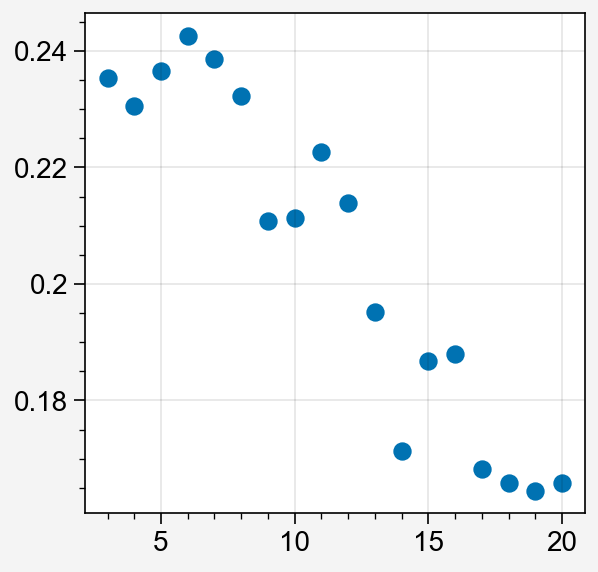

In [ ]:
'''
Add meta clustering to the forced trajectory gradients, which is what we designed the
data set for
'''
ares = pickle.load(open('data/meta_rnn_gradients', 'rb'))
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))

# 1. Generate meta clusters and orient them for all of the clusters found
print('Largest number of clusters:', max([max(l) for l in ares['cluster_labels'].values()])+1)
all_idxs = list(forced_ares['cluster_activations'].keys())
activ = np.hstack(list(forced_ares['cluster_activations'].values()))
scaler = TimeSeriesScalerMeanVariance()
activ_normalized = scaler.fit_transform(activ.T[:, :, np.newaxis])  # Shape becomes [64, T, 1]
activ_normalized = activ_normalized.squeeze()  # Back to shape [64, T]
combactiv = np.vstack([activ_normalized, -activ_normalized])

max_k = 20  # Maximum number of clusters to try
silhouette_scores = []
ks = range(3, max_k + 1)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(combactiv)
    silhouette_avg = silhouette_score(combactiv, labels)
    silhouette_scores.append(silhouette_avg)

best_k = np.argmax(silhouette_scores) + 3
fig, ax = pplt.subplots()
ax.scatter(np.arange(3, 21), silhouette_scores)

kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(combactiv)
orientation = []
labels = []
for i in range(activ.shape[1]):
    right_dist = np.linalg.norm(kmeans.cluster_centers_ - activ[:, i], axis=1)
    left_dist = np.linalg.norm(kmeans.cluster_centers_ + activ[:, i], axis=1)

    if right_dist.min() < left_dist.min():
        orientation.append(1)
        labels.append(np.argmin(right_dist))
    else:
        orientation.append(-1)
        labels.append(np.argmin(left_dist))

k = best_k
labels = np.array(labels)
orientation = np.array(orientation)
oriented_activ = (activ_normalized * orientation.reshape(-1, 1)).T

forced_ares['all_oriented_cactiv'] = oriented_activ

# 2. Calculate the distances from clusters to their meta cluster centers
cdists = []
for i in range(activ.shape[1]):
    a = activ[:, i]
    l = labels[i]
    c = kmeans.cluster_centers_[l]
    d = np.sqrt(np.sum((c - a)**2))
    cdists.append(d)
cdists = np.array(cdists)
clusters_per_agent = []
for idx in all_idxs:
    clusters_per_agent.append(forced_ares['cluster_activations'][idx].shape[1])

# 3. Add labels to each cluster for each agent based on their assigned meta cluster
# and add orientation information
per_agent_labels = {}
per_agent_orientations = {}
per_agent_cdists = {}
cur = 0
for i, n in enumerate(clusters_per_agent):
    idx = all_idxs[i]
    nxt = cur + n
    per_agent_labels[idx] = labels[cur:nxt]
    per_agent_orientations[idx] = orientation[cur:nxt]
    per_agent_cdists[idx] = cdists[cur:nxt]
    cur = nxt

forced_ares['per_agent_labels'] = per_agent_labels
forced_ares['per_agent_orientations'] = per_agent_orientations
forced_ares['per_agent_cdists'] = per_agent_cdists
forced_ares['labels'] = labels
forced_ares['orientations'] = orientation
forced_ares['kmeans'] = kmeans
forced_ares['cdists'] = cdists

pickle.dump(forced_ares, open('data/meta_rnn_forced_gradients', 'wb'))

In [ ]:
from scipy.stats import pearsonr
from itertools import combinations
'''Compute node based meta clusters'''
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))

all_idxs = select_chks_by_dimension()
comb_rnn_hxs = np.hstack([forced_ares['all_rnn_hxs'][idx] for idx in all_idxs])
scaler = TimeSeriesScalerMeanVariance()
activ_normalized = scaler.fit_transform(comb_rnn_hxs.T[:, :, np.newaxis])
activ_normalized = activ_normalized.squeeze()
combactiv = np.vstack([activ_normalized, -activ_normalized])
norm_activ = activ_normalized.T

k = 12
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(combactiv)
centers = kmeans.cluster_centers_
N, T = centers.shape
redundant_pairs = []
redundant_set = set()

# determine which clusters are symmetrical
for i, j in combinations(range(N), 2):
    corr, _ = pearsonr(centers[i], centers[j])
    if corr <= -0.90:
        redundant_pairs.append((i, j))
        redundant_set.add(j)
        redundant_set.add(i)
for i in range(N):
    if i not in redundant_set:
        redundant_pairs.append((i,))
        redundant_set.add(i)
redundant_pairs
keep_centers = [centers[pair[0]] for pair in redundant_pairs]
keep_centers = np.vstack(keep_centers)

# orient nodes with respect to clusters
orientation = []
labels = []
for i in range(norm_activ.shape[1]):
    right_dist = np.linalg.norm(keep_centers - norm_activ[:, i], axis=1)
    left_dist = np.linalg.norm(keep_centers + norm_activ[:, i], axis=1)
    if right_dist.min() < left_dist.min():
        orientation.append(1)
        labels.append(np.argmin(right_dist))
    else:
        orientation.append(-1)
        labels.append(np.argmin(left_dist))
dists = []
for i in range(norm_activ.shape[1]):
    dists.append(np.linalg.norm(
                keep_centers[labels[i]] - norm_activ[:, i]*orientation[i]))

# Save kmeans object, labels, orientation
agent_node_meta_labels = {}
agent_node_meta_orientation = {}
k = 6
manual_reordering = [0, 2, 4, 1, 3, 5]
node_meta_kmeans = KMeans(n_clusters=len(keep_centers), n_init=1,
                          init=[keep_centers[i] for i in manual_reordering])
node_meta_kmeans.fit((norm_activ * orientation).T)
node_meta_kmeans.cluster_centers_ = [keep_centers[i] for i in manual_reordering]
cur = 0
for idx in all_idxs:
    agent_node_meta_labels[idx] = labels[cur:cur+64]
    agent_node_meta_orientation[idx] = orientation[cur:cur+64]
    cur = cur + 64

forced_ares['node_kmeans'] = node_meta_kmeans
forced_ares['agent_node_meta_labels'] = agent_node_meta_labels
forced_ares['agent_node_meta_orientation'] = agent_node_meta_orientation

# Fit agents into one of 3 types depending on node cluster distribution
idxs = select_chks_by_dimension()
labels = np.zeros((2, 4, 5, 10) + (k,))
for idx in idxs:
    for c in range(k):
        labels[idx][c] = (np.array(forced_ares['agent_node_meta_labels'][idx]) == c).sum() / 64
clusters = labels.reshape(-1, k)
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
agent_labels = kmeans.fit_predict(clusters).reshape(2, 4, 5, 10)
forced_ares['agent_cluster_type'] = agent_labels
forced_ares['agent_type_kmeans'] = kmeans

pickle.dump(forced_ares, open('data/meta_rnn_forced_gradients', 'wb'))

In [ ]:
'''
Compute contribution of each meta cluster to policy and value on average
and activation connectivity matrix
'''
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb'))

# Can change the commented out weight lines to change whether we weight
#  each clusters contribution by how far it is to its meta cluster center
max_cdist = np.max(forced_ares['cdists'])

per_agent_action_grads = {}
per_agent_value_grads = {}

# 1. Calculate contribution of each cluster to its own agent's
#  policy and value, average these contributions for the whole meta cluster
all_cluster_val_grad = {}
for i in range(k):
    all_cluster_val_grad[i] = []

for idx in all_idxs:
    rnn_labels = ares['cluster_labels'][idx]
    rnn_val_grad = ares['val_grads'][idx]
    rnn_k = max(rnn_labels) + 1
    meta_cluster_labels = forced_ares['per_agent_labels'][idx]
    cdist = forced_ares['per_agent_cdists'][idx]
    # weight = (max_cdist - cdist) / max_cdist
    weight = 1
    cvalgrad = np.array([(rnn_val_grad[rnn_labels == i]).mean() for i in range(rnn_k)])
    cvalgrad = cvalgrad * weight
    for i, label in enumerate(meta_cluster_labels):
        all_cluster_val_grad[label].append(cvalgrad[i])
    per_agent_value_grads[idx] = cvalgrad.copy()
    
all_cluster_action_grad = {}
for i in range(k):
    all_cluster_action_grad[i] = []

for idx in all_idxs:
    try:
        rnn_labels = ares['cluster_labels'][idx]
        rnn_val_grad = ares['action_grads'][idx]
        rnn_k = max(rnn_labels) + 1
        meta_cluster_labels = forced_ares['per_agent_labels'][idx]
    except:
        continue
    cdist = forced_ares['per_agent_cdists'][idx]

    # weight = (max_cdist - cdist) / max_cdist
    weight = 1

    cvalgrad = np.array([(rnn_val_grad[rnn_labels == i]).mean() for i in range(rnn_k)])
    cvalgrad = cvalgrad * weight
    for i, label in enumerate(meta_cluster_labels):
        all_cluster_action_grad[label].append(cvalgrad[i])
    per_agent_action_grads[idx] = cvalgrad.copy()

# 2. Use t-test to determine which clusters have significant impact
#  on policy or value
val_grads = np.concatenate(list(all_cluster_val_grad.values()))
act_grads = np.concatenate(list(all_cluster_action_grad.values()))
val_scores = []
pol_scores = []
for i in range(k):
    t = ttest_ind(all_cluster_val_grad[i], val_grads)
    if t.statistic > 0:
        val_scores.append(1 - t.pvalue)
    else:
        val_scores.append(None)
    t = ttest_ind(all_cluster_action_grad[i], act_grads)
    if t.statistic > 0:
        pol_scores.append(1 - t.pvalue)
    else:
        pol_scores.append(None)

# 3. Calculate meta cluster influence connectivity
max_cdist = np.max(forced_ares['cdists'])
all_influences = np.zeros((k, k))
pair_counts = np.zeros((k, k))

for idx in all_idxs:
    influences = ares['rnn_hx_influences'][idx]
    labels = ares['cluster_labels'][idx]
    meta_labels = forced_ares['per_agent_labels'][idx]
    infl_table = get_cluster_influences(influences, labels)

    cdist = forced_ares['per_agent_cdists'][idx]
    # weight = (max_cdist - cdist) / max_cdist
    weight = 1
    
    for i in range(len(meta_labels)):
        for j in range(len(meta_labels)):
            meta_to = meta_labels[i]
            meta_from = meta_labels[j]
            # all_influences[meta_to, meta_from] += infl_table[i, j] * weight[i] * weight[j]
            all_influences[meta_to, meta_from] += infl_table[i, j] 
            pair_counts[meta_to, meta_from] += 1

cluster_influences = all_influences / pair_counts
        
forced_ares['per_agent_action_grads'] = per_agent_action_grads
forced_ares['per_agent_value_grads'] = per_agent_value_grads
forced_ares['meta_cluster_action_grads'] = all_cluster_action_grad
forced_ares['meta_cluster_value_grads'] = all_cluster_val_grad
forced_ares['meta_cluster_action_scores'] = pol_scores
forced_ares['meta_cluster_value_scores'] = val_scores
forced_ares['meta_cluster_influences'] = cluster_influences
forced_ares['all_value_grads'] = np.concatenate(list(forced_ares['per_agent_value_grads'].values()))
forced_ares['all_action_grads'] = np.concatenate(list(forced_ares['per_agent_action_grads'].values()))

pickle.dump(forced_ares, open('data/meta_rnn_forced_gradients', 'wb'))

## Larger set of forced trajectories to detect bimodal RNN stability

In [ ]:
balloon_limits, forced_actions = pickle.load(open('data/metabart_forced_lim_acts_10', 'rb'))
give_env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0, 'give_rew': True,
                            'pop_noise': 0, 'fix_sizes_per_balloon': True,
                            'fix_sizes': s} for s in balloon_limits]
fixprev_env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0, 'fix_prev_action_bug': True,
                            'pop_noise': 0, 'fix_sizes_per_balloon': True,
                            'fix_sizes': s} for s in balloon_limits]

# Note, seed does not matter since we are fixing the exact sizes of each balloon that appears
force_give_evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=give_env_kwargs, 
                forced_actions=forced_actions,
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)
force_fixprev_evalu_ = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=fixprev_env_kwargs, 
                forced_actions=forced_actions,
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

def force_evalu(model, obs_rms, give_rew=False):
    if give_rew:
        res = force_give_evalu_(model, obs_rms)
    else:
        res = force_fixprev_evalu_(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=50)
    return res

In [ ]:
"""
Main section to collect a bunch of data on confidence, activations
and ramping signal
"""
import warnings
from diptest import diptest
warnings.filterwarnings("ignore")

give_rew = ['giverew_', 'fixprev_']
postfixes = ['pop0', 'pop0.1', 'pop0.2', 'pop0.4']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(10)
chks = pickle.load(open('data/meta_representation_first_idxs', 'rb'))
used_chks = np.arange(40, 243, 30)

iterators = [give_rew, postfixes, models, trials]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
# Performance
all_rnn_hxs = {}
all_bimodal_nodes = np.zeros(sizes + [64,])
all_has_bimodal_rnn = np.zeros(sizes)

for h, i, j, k in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    idx = (h, i, j, k)
    
    chk = used_chks[chks[h, i, j, k]]
        
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
        
    give = True if h == 0 else False
    res = force_evalu(model, obs_rms, give_rew=give)
    
    activ = np.vstack(res['rnn_hxs'])

    all_rnn_hxs[idx] = activ
    
    # Check bimodal RNN structure
    rnn_hxs = np.vstack(res['rnn_hxs'])
    lens = [len(o) for o in res['obs']]
    data = rnn_hxs.T  # change to [64, T]
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data[:, :, np.newaxis])  # Shape becomes [64, T, 1]
    rnn_hxs = data_normalized.squeeze().T  # Back to shape [T, 64]
    pca = PCA(n_components=5)
    rnn_pc = pca.fit_transform(rnn_hxs)
    ep_rnn = split_by_lens(lens, rnn_pc)

    ep_mean_rnn = [r.mean(axis=0) for r in ep_rnn]
    ep_mean_rnn = np.vstack(ep_mean_rnn)
    ps = []
    for i in range(ep_mean_rnn.shape[1]):
        _, p = diptest(ep_mean_rnn[:, i])
        ps.append(p)
    i = np.argmin(ps)
    comp = np.abs(pca.components_[i])
    perc = np.percentile(comp, 80)    
    all_bimodal_nodes[idx] = (comp > perc) * 1
    all_has_bimodal_rnn[idx] = (min(ps) < 0.05) * 1


# Add behavioral data for forced trajectories
idx = (0, 0, 0, 0)
idx = select_chks([idx])[0]
model, obs_rms = metabart_model_load(idx)
r_give = force_evalu(model, obs_rms, give_rew=True)

idx = (1, 0, 0, 0)
idx = select_chks([idx])[0]
model, obs_rms = metabart_model_load(idx)
r_fixprev = force_evalu(model, obs_rms)

del r_give['activations']
del r_give['rnn_hxs']
del r_give['action_log_probs']
del r_give['action_probs']
del r_fixprev['activations']
del r_fixprev['rnn_hxs']
del r_fixprev['action_log_probs']
del r_fixprev['action_probs']


pickle.dump({
    'all_rnn_hxs': all_rnn_hxs,
    'bimodal_rnn': all_has_bimodal_rnn,
    'bimodal_nodes': all_bimodal_nodes,
    'fixprev_res': r_fixprev,
    'give_res': r_give,
}, open('data/meta_rnn_forced_gradients_10', 'wb'))

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [19:06<00:00,  2.87s/it]


# Individual node stimulus experiment

In [ ]:
"""
Main section to collect a bunch of data on confidence, activations
and ramping signal
"""
import warnings
warnings.filterwarnings("ignore")

give_rew = ['giverew_', 'fixprev_']
postfixes = ['pop0', 'pop0.1', 'pop0.2', 'pop0.4']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(10)
chks = pickle.load(open('data/meta_representation_first_idxs', 'rb'))
used_chks = np.arange(40, 243, 30)

iterators = [give_rew, postfixes, models, trials]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

# indexed by model, then layer (shared0/1, actor0/1, critic0/1), finally index
#  first is fit to all activations, then fit to PCA i-1
response_types = np.zeros(sizes + [64])
turning_points = np.zeros(sizes + [64])
lr_sens_bias = np.zeros(sizes + [64])
size_sensitivities = np.zeros(sizes + [6, 20, 64])
pop_sensitivities = np.zeros(sizes + [20, 64])
reversals = np.zeros(sizes + [64])

for h, i, j, k in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    if h == 0:
        give = True
        fixprev = False
    elif h == 1:
        give = False
        fixprev = True
    idx = (h, i, j, k)
    postfix = postfixes[i]
    model = models[j]
    t = k
    chkidx = select_chks([idx])[0]
    # print(idx, chkidx)
    model, obs_rms = metabart_model_load(chkidx)
    
    r = calculate_all_single_node_characteristics(model, obs_rms, give=give, fix_bug=fixprev,
                                                  recovery_diffs=True)
    response_types[idx] = r[0]
    turning_points[idx] = r[1]
    lr_sens_bias[idx] = r[2]
    size_sensitivities[idx] = r[3]
    pop_sensitivities[idx] = r[4]
    reversals[idx] = r[5]
    
pickle.dump({
    'response_types': response_types,
    'turning_points': turning_points,
    'lr_sens_bias': lr_sens_bias,
    'size_sensitivities': size_sensitivities,
    'pop_sensitivities': pop_sensitivities,
    'reversals': reversals,
}, open('data/meta_single_node_characteristics', 'wb'))

100%|██████████| 400/400 [19:33<00:00,  2.93s/it]


In [ ]:
'''
Add recovery time to size or pop stimulation to node_ares
'''

node_ares = pickle.load(open('data/meta_single_node_characteristics', 'rb'))

size_recoveries = np.zeros(node_ares['size_sensitivities'][:, :, :, :, 0, 0, :].shape)
pop_recoveries = np.zeros(node_ares['pop_sensitivities'][:, :, :, :, 0, :].shape)

iterators = [give_rew, postfixes, models, trials]
iterators_idxs = [range(len(i)) for i in iterators]

for h, i, j, k in itertools.product(*iterators_idxs):
    size_sens = node_ares['size_sensitivities'][h, i, j, k]
    pop_sens = node_ares['pop_sensitivities'][h, i, j, k]
    num_stims = size_sens.shape[0]
    
    # Size recovery rate
    recoveries = np.zeros((num_stims, 64))
    for n in range(64):
        for m in range(num_stims):
            recov = size_sens[m, :, n] < 0.05
            if np.all(~recov):
                recoveries[m, n] = 20
            else:
                recoveries[m, n] = np.argmax(recov)
    mean_recoveries = recoveries.mean(axis=0)
    size_recoveries[h, i, j, k] = mean_recoveries

    # Pop recovery rate
    recoveries = np.zeros(64)
    for n in range(64):
        recov = pop_sens[:, n] < 0.05
        if np.all(~recov):
            recoveries[n] = 20
        else:
            recoveries[n] = np.argmax(recov)
    pop_recoveries[h, i, j, k] = recoveries

node_ares['size_recoveries'] = size_recoveries
node_ares['pop_recoveries'] = pop_recoveries

pickle.dump(node_ares, open('data/meta_single_node_characteristics', 'wb'))

In [18]:
chkidxs = select_chks_by_dimension(with_chk=True)
for chkidx in chkidxs:
    h, i, j, k, l = chkidx
    give_rew = ['giverew_', 'fixprev_']
    postfixes = ['pop0', 'pop0.1', 'pop0.2', 'pop0.4']
    models = [1.0, 1.2, 1.5, 1.7, 2.0]
    trials = range(10)
    chks = np.arange(40, 243, 30)
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]

    exp_name = f"{give}p{model}n50{postfix}"

    from_folder = Path(f'../saved_checkpoints/meta_v2/{exp_name}_{t}')
    to_folder = Path(f'../saved_checkpoints/transfer/{exp_name}_{t}')
    to_folder.mkdir(parents=True, exist_ok=True)
    source = from_folder/f'{chk}.pt'
    target = to_folder/f'{chk}.pt'
    shutil.copy2(source, target)
